<a href="https://colab.research.google.com/github/rrfsantos/Desafios-NLP/blob/main/Desafio-NLP--Classificacao/Tweets_Covid_19_AnaliseSentimentos_GloVe_LSTM_5_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de sentimentos (classificação) de tweets relacionados a COVID-19

### Dataset: Coronavirus tweets NLP - Text Classification - https://www.kaggle.com/datatattle/covid-19-nlp-text-classification




In [ ]:
!pip install contractions

In [ ]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import nltk
import spacy
import re
import string
import unicodedata
import warnings
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
%matplotlib inline

from contractions import contractions_dict
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from tensorflow import keras
from keras.preprocessing import sequence
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam, SGD
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, ConfusionMatrixDisplay
from sklearn import metrics

from wordcloud import WordCloud
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer

warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#!python -m spacy download en_core_web_md
#!python -m spacy link en_core_web_md en --force

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/desafio 1/'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Carregar as bases de treino e teste
df_train = pd.read_csv('Corona_NLP_train.csv', engine='python')
df_test = pd.read_csv('Corona_NLP_test.csv', engine='python')

In [ ]:
df_train = df_train[['OriginalTweet', 'Sentiment']]
df_test = df_test[['OriginalTweet', 'Sentiment']]

In [ ]:
train = len(df_train)
test = len(df_test)

print('Número de Tweets na base de treino: ', train)
print('Número de Tweets na base de test: ', test)

Número de Tweets na base de treino:  41157
Número de Tweets na base de test:  3798


In [ ]:
df_train['OriginalTweet'][20]

'with 100  nations inficted with  covid  19  the world must  not  play fair with china  100 goverments must demand  china  adopts new guilde  lines on food safty  the  chinese  goverment  is guilty of  being  irosponcible   with life  on a global scale'

## Pré-processamento da base

#### Concatenar bases teste e treino para pré-processamento

In [ ]:
df_covid = df_train.append(df_test, ignore_index=True)

In [ ]:
df_covid['OriginalTweet'][20]

'with 100  nations inficted with  covid  19  the world must  not  play fair with china  100 goverments must demand  china  adopts new guilde  lines on food safty  the  chinese  goverment  is guilty of  being  irosponcible   with life  on a global scale'

#### Simplificar contrações e expressões

In [ ]:
df_covid['OriginalTweet'] = df_covid.replace({'OriginalTweet': contractions_dict},regex=True)

#### Remover caracteres especiais e transformar os demais em minúsculos

In [ ]:
def remove_special_characters(text):
  
  special_char_pattern = re.compile(r'([{.(-)!}])')
  text = special_char_pattern.sub(" \\1 ", text)

  pattern = r'[^a-zA-z0-9\s]'
  text = re.sub(pattern, '', text)
  text = re.sub('_', ' ', text)
  text = re.sub(r'http\S+', '', text)
  text = re.sub('&amp', ' ', text)
  text = re.sub(r'[^ \\t\w\.]', '', text)
  soup = BeautifulSoup(text, "html.parser")
  text = soup.get_text()
  text = re.sub(r"\s+"," ",text).strip()
  return text

df_covid['OriginalTweet'] = df_covid.OriginalTweet.map(remove_special_characters).str.lower()

#### Lemetização

In [ ]:
#nlp = spacy.load('en')

#def lemmatize(text):
#  text = nlp(text)
#  text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
#  return text

#df_covid['OriginalTweet'] = df_covid.OriginalTweet.map(lemmatize)

#### Tokenizar

In [ ]:
#tk = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

#df_covid['OriginalTweet'] = df_covid.OriginalTweet.apply(tk.tokenize)

#### Remover stop words

In [ ]:
#stopword_list = nltk.corpus.stopwords.words('english')
#new_stopwords = ['pic','twitter','com','amp']
#stopword_list.extend(new_stopwords)
#stopword_list.remove('no')
#stopword_list.remove('not')

#stop_lambda = lambda x: [y for y in x if y not in stopword_list]

#df_covid['OriginalTweet'] = df_covid.OriginalTweet.map(stop_lambda)

In [ ]:
df_covid['OriginalTweet'][20]

'with 100 nations inficted with covid 19 the world must not play fair with china 100 goverments must dthemand china adopts new guilde lines on food safty the chinese goverment is guilty of being irosponcible with life on a global scale'

#### Verificar valores nulos após a limpeza da base

In [ ]:
print('df_covid.OriginalTweet: ', (df_covid.OriginalTweet.isna()).sum())
print('df_covid.Sentiment: ',(df_covid.Sentiment.isna()).sum())

df_covid.OriginalTweet:  0
df_covid.Sentiment:  0


## Análises estatísticas

#### Distribuição de tweets por Classe

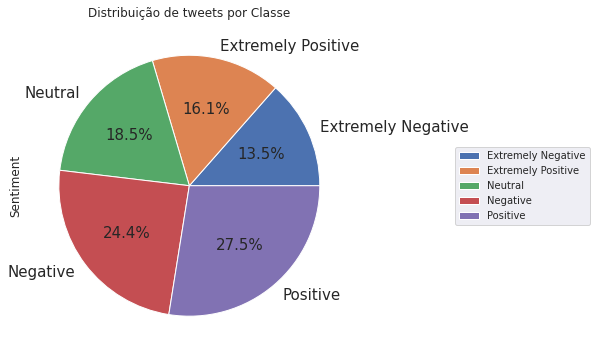

In [ ]:
df_distribution = df_covid.Sentiment.value_counts()\
                            .to_frame()\
                            .sort_values('Sentiment')

df_distribution.plot.pie(y='Sentiment', autopct='%1.1f%%',\
                            title='Distribuição de tweets por Classe',\
                            figsize=(6, 6), textprops = {"fontsize": 15}, labeldistance = 1.1)\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5),fontsize='medium')

plt.show;   

#### Tamanho dos tweets por classe

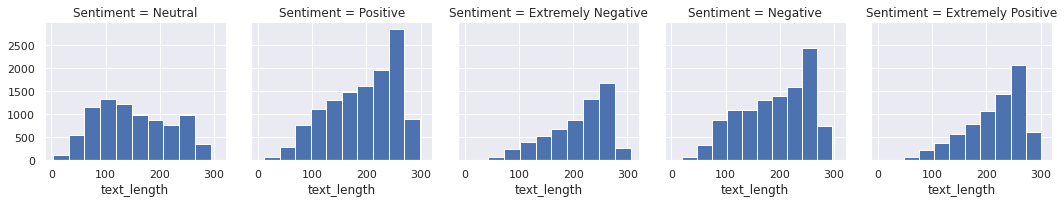

In [ ]:
df_covid['text_length'] = df_covid.OriginalTweet.apply(len)
sns.set(font_scale = 1)
g = sns.FacetGrid(df_covid,col='Sentiment')
g.map(plt.hist,'text_length')
plt.show();

#### Quantidade de caracteres nos tweets

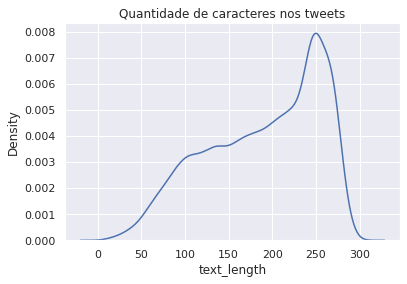

In [ ]:
sns.distplot(df_covid.text_length, hist=False)
plt.title('Quantidade de caracteres nos tweets')
plt.show();

#### Distribuição da quantidade de palavras nos tweets

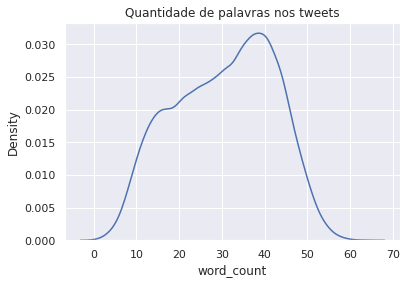

In [ ]:
df_covid['word_count'] = df_covid.OriginalTweet.apply(lambda x: len(str(x).split()))
sns.distplot(df_covid.word_count, hist=False)
plt.title('Quantidade de palavras nos tweets')
plt.show();

## WordCloud

### Unigrams

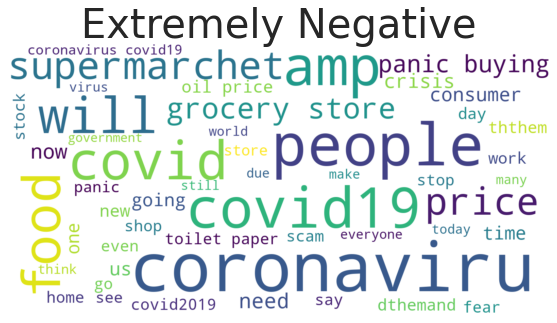

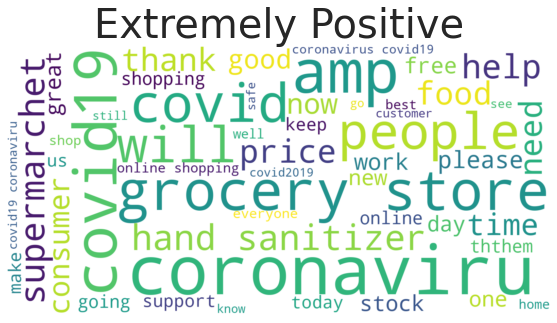

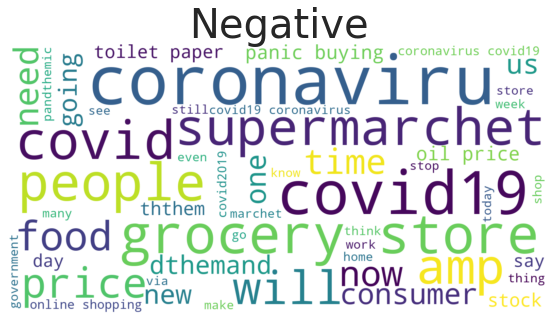

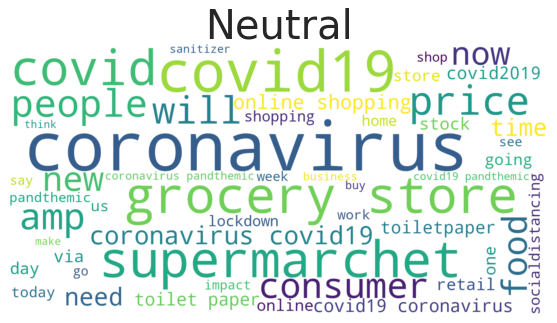

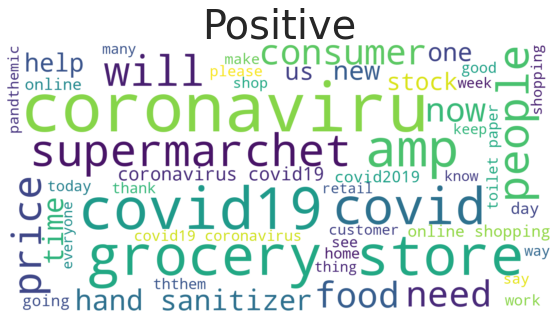

In [ ]:
### Converte lista strings em um único texto
labels = np.unique(df_covid.Sentiment)
for label in labels:
    rows = df_covid[df_covid.Sentiment == label]
    corpus = " ".join(text for text in rows.OriginalTweet)
      
    ## Plotagem da WordCloud       
    cloud = WordCloud(background_color='white',width=1600,height=800,\
                      max_font_size=200,max_words=50).generate(corpus)

    plt.figure(figsize = (10,5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(label, fontsize=40)
    plt.axis('off')
    plt.show;  

### Bigrams

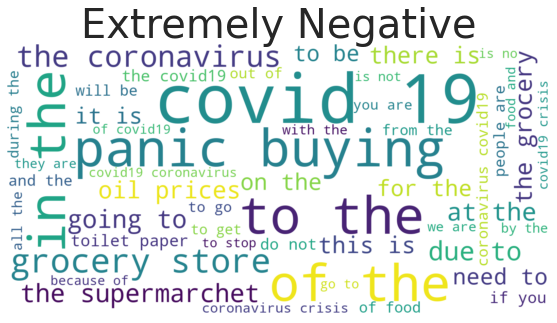

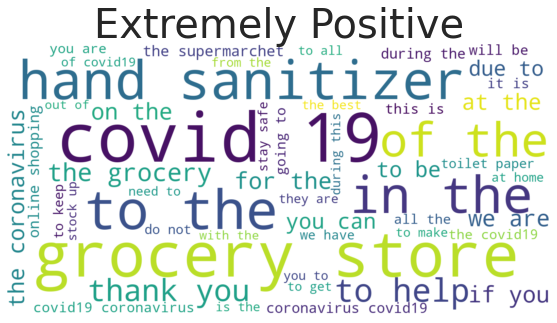

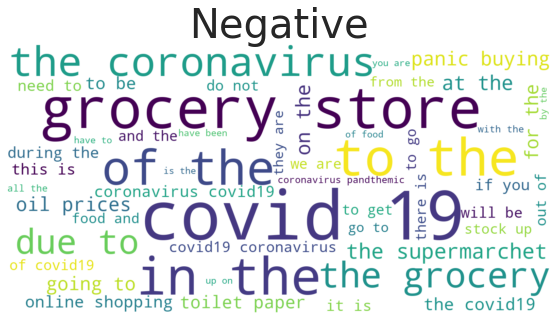

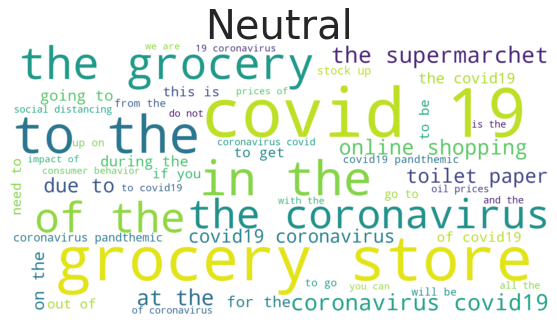

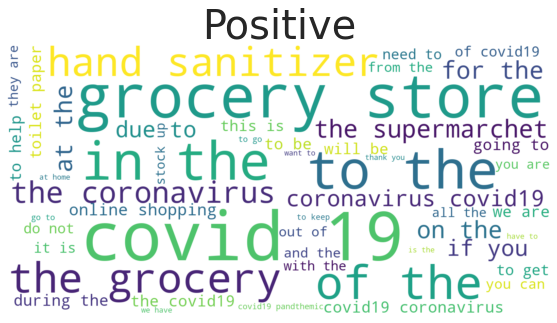

In [ ]:
### Converte lista de strings em um único texto
labels = np.unique(df_covid.Sentiment)
corpus = []
for label in labels:
    rows = df_covid[df_covid.Sentiment == label]
    corpus = " ".join(text for text in rows.OriginalTweet)
    vec = CountVectorizer(ngram_range=(2, 2)).fit([corpus])
    bag_of_words = vec.transform([corpus])
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    most_common = dict(words_freq)

       ## Plotagem da WordCloud       
    cloud = WordCloud(background_color='white',width=1600,height=800,\
                      max_font_size=200,max_words=50).generate_from_frequencies(most_common)

    plt.figure(figsize = (10,5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(label, fontsize=40)
    plt.axis('off')
    plt.show;

   

### Trigrams

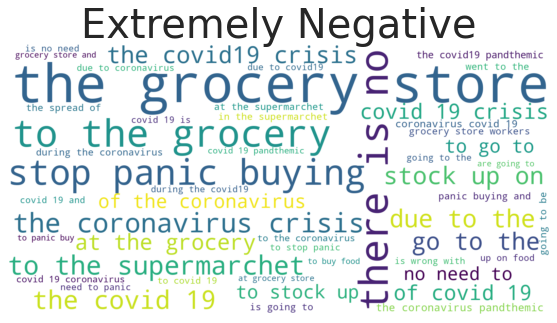

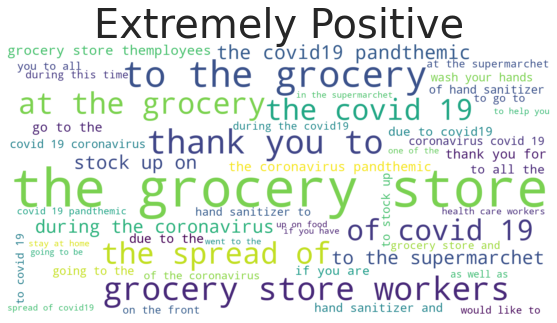

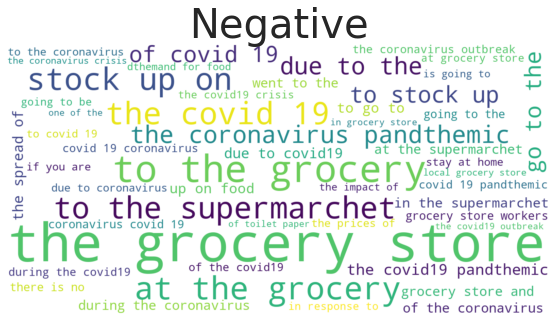

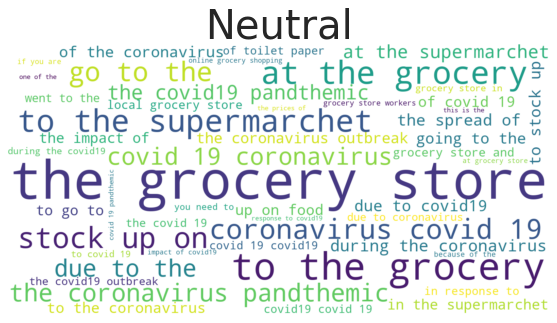

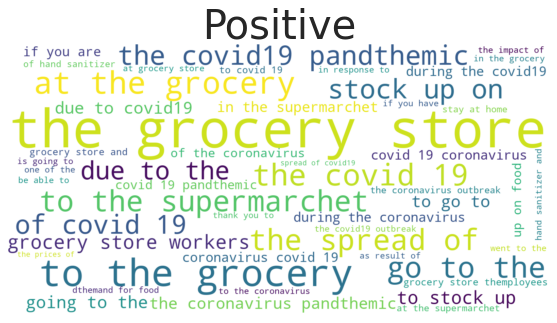

In [ ]:
### Converte lista de strings em um único texto
labels = np.unique(df_covid.Sentiment)
corpus = []
for label in labels:
    rows = df_covid[df_covid.Sentiment == label]
    corpus = " ".join(text for text in rows.OriginalTweet)
    vec = CountVectorizer(ngram_range=(3,3)).fit([corpus])
    bag_of_words = vec.transform([corpus])
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    most_common = dict(words_freq)

       ## Plotagem da WordCloud       
    cloud = WordCloud(background_color='white',width=1600,height=800,\
                      max_font_size=200,max_words=50).generate_from_frequencies(most_common)

    plt.figure(figsize = (10,5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(label, fontsize=40)
    plt.axis('off')
    plt.show;

## Análise de Sentimentos - Classificação dos Tweets - Embedding e CNN-LSTM

#### Dividir a base em dados e labels (X,y)

In [ ]:
X = df_covid.OriginalTweet
y = pd.get_dummies(df_covid['Sentiment']).values

In [ ]:
X_train = X[:train]
X_test = X[train:]
y_train = y[:train]
y_test = y[train:]

#### Variáveis

In [ ]:
batch_size = 32
epochs = 30
max_features = 30000 # número máximo de palavras utilizado para o vocabulário (número de "vetores de palavras")
init_lr = 1e-2
seed = 100
num_classes = df_covid['Sentiment'].nunique()

#### Criar os vetores de palavras

In [ ]:
max_features = max_features
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
max_words = 100 # número máximo de palavras em um comentário
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(41157, 100) (3798, 100)


#### Callbacks

In [ ]:
es = EarlyStopping(patience=5, restore_best_weights=True, verbose = True, monitor='val_loss', mode='min')
mc = ModelCheckpoint(filepath='best_model.h5', save_best_only=True, verbose=True, monitor='val_loss', mode='min')
rlr = ReduceLROnPlateau(patience = 2, verbose = True, factor=0.5, monitor='val_loss', restore_best_weights=True, mode='min')

#### Otimizador

In [ ]:
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #init_lr,
    #decay_steps=init_lr / epochs,
    #decay_rate=0.9)
opt = Adam(learning_rate=init_lr)

#### Função para montar a embedding_matrix

In [ ]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
    
def get_embed_mat(EMBEDDING_FILE, max_features=max_features):
    # word vectors
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding='utf8'))
    print('Found %s word vectors.' % len(embeddings_index))

    # embedding matrix
    word_index = tokenizer.word_index
    num_words = min(max_features, len(word_index) + 1)
    all_embs = np.stack(embeddings_index.values()) #for random init
    embedding_matrix = np.random.normal(all_embs.mean(), all_embs.std(), 
                                        (num_words, embed_dim))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    max_features = embedding_matrix.shape[0]
    
    return max_features, embedding_matrix

#### Função para montar a Rede Neural

In [ ]:
def get_model(max_features, embed_dim, embedding_matrix):
    np.random.seed(seed)
    K.clear_session()
           
    model = Sequential()

    ## Camada Embedding
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1],
                       weights=[embedding_matrix], trainable = True))
    
    ## Camada Convolucional
    #model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))

    ## Camadas LSTM
    #model.add(LSTM(embed_dim, dropout=0.25, return_sequences = True))
    model.add(LSTM(embed_dim, dropout=0.2, recurrent_dropout=0.2))

    ## Camadas FC - Fazem a classificação
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='sigmoid'))


    model.compile(loss='binary_crossentropy', optimizer = opt, metrics=['acc'])
    print(model.summary())
    return model

#### Função para treinar a Rede Neural

In [ ]:
def model_train(model):
    # train the model
    model_history = model.fit(X_train, y_train, validation_split=0.2, 
                          epochs=epochs, batch_size=batch_size, verbose=2,callbacks=[es,rlr,mc])
    # plot train history
    plot_model_history(model_history)

#### Função verificação do Histórico de Treinamento

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show();

#### Função para avalição da Rede Neural

In [ ]:
def model_evaluate(): 
    # predict class with test set
    y_pred_test =  model.predict_classes(X_test, batch_size=batch_size, verbose=0)
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))
    
    #classification report
    print('\n')
    print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

    #confusion matrix
    confmat = confusion_matrix(np.argmax(y_test,axis=1), y_pred_test)

    fig, ax = plt.subplots(figsize=(10,10))
    ConfusionMatrixDisplay(confusion_matrix = confmat, display_labels = labels)\
                          .plot(cmap='Blues', xticks_rotation='vertical', ax=ax)
   
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show();

Found 1193514 word vectors.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                3232      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 3,083,797
Trainable params: 3,083,797
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
1029/1029 - 238s - loss: 0.3710 - acc: 0.5387 - val_loss: 0.2711 - v

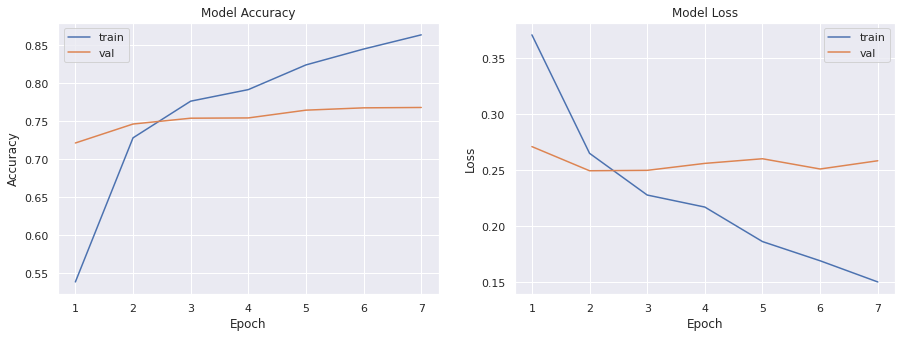

In [ ]:
# embedding matrix
EMBEDDING_FILE = 'glove.twitter.27B.100d.txt' ### Teste anterior com glove.6B.100d.txt
embed_dim = 100 # --> Cada palavra é representada por um vetor de 100 dimensões (glove.6B.100d.txt)
max_features, embedding_matrix = get_embed_mat(EMBEDDING_FILE)

# train the model
model = get_model(max_features, embed_dim, embedding_matrix)
model_train(model)

Accuracy:	71.6%


              precision    recall  f1-score   support

           0       0.75      0.75      0.75       592
           1       0.79      0.73      0.76       599
           2       0.66      0.67      0.66      1041
           3       0.81      0.77      0.79       619
           4       0.66      0.71      0.68       947

    accuracy                           0.72      3798
   macro avg       0.73      0.72      0.73      3798
weighted avg       0.72      0.72      0.72      3798



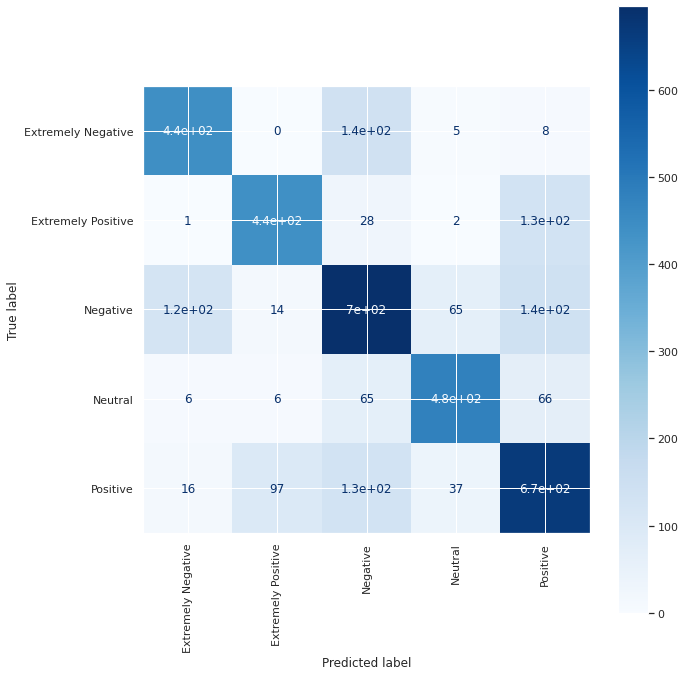

In [ ]:
model_evaluate()